In [1]:
import pyedflib
import numpy as np

import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker

from sklearn.metrics import precision_score , recall_score, confusion_matrix,  ConfusionMatrixDisplay
%matplotlib inline

In [4]:
file_name = "data/record0.edf"
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

In [5]:
time = [1/f.samplefrequency(0) * i for i in range(len(sigbufs[0]))]
events = f.readAnnotations()[0]  

In [2]:
def Labeling(time, events):
    labels = np.zeros_like(time)
    for event in events:
        idx = np.array(time < event).argmin()
        if idx - 20 < 0:
            labels[idx:idx + 20] = 1
        elif idx + 20 >= len(time):
            labels[idx - 20:idx] = 1
        else:
            labels[idx - 20:idx + 20] = 1
    return labels
        

In [3]:
labels = np.load("data/labels.npy")

Let's test 6000 - 6800 sec, using only half of record to increase balance of classess

In [10]:
test_idx = (np.array(time) < 6000).argmin()
test_idx2 = (np.array(time)< 6800).argmin()
test_x = sigbufs[:, test_idx:test_idx2]
test_labels = labels[test_idx:test_idx2]


train_x1 = sigbufs[:, sigbufs[0].shape[0] // 2:test_idx]
train_x2 = sigbufs[:, test_idx2:]
train_labels1 = labels[sigbufs[0].shape[0] // 2:test_idx]
train_labels2 = labels[test_idx2:]

Let's test 4000 points in sample

In [15]:
RECEPTIVE_FIELD = 4000

def CreateSamples(x, labels, rf = RECEPTIVE_FIELD):
    inout_seq = []
    L = x.shape[-1]
    for i in tqdm(range(0, L- rf, rf)):
        train_seq = x[:, i:i+rf]
        train_label = labels[i:i+rf]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
    

In [18]:
test_samples = CreateSamples(test_x, test_labels)
train_samples = CreateSamples(train_x1, train_labels1) + CreateSamples(train_x2, train_labels2)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<?, ?it/s]


In [19]:
train_dataloader = DataLoader(train_samples, batch_size=15, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_samples, batch_size=13, shuffle=False, drop_last=True)

In [24]:
for idx, (x, y) in enumerate(train_dataloader):
    print(x.shape)
    print(y[:, None, :].shape)    
    break

torch.Size([15, 20, 4000])
torch.Size([15, 1, 4000])


In [66]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)
        
        return out       

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()
        
        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)
        
        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()
        
        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)
    
    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out          

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5, padding=8)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25, padding=8)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125, padding=8)
        
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        self.layer5 = self.down_layer(int(self.layer_n*4)+int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest')
        
        self.outcov = nn.Conv1d(self.layer_n, 2, kernel_size=self.kernel_size, stride=1,padding = 3)
    
        
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)
            
    def forward(self, x):
        
        pool_x1 = self.AvgPool1D1(x)
        pool_x2 = self.AvgPool1D2(x)
        pool_x3 = self.AvgPool1D3(x)
        
        #############Encoder#####################
        
        out_0 = self.layer1(x)
        out_1 = self.layer2(out_0)        
        
        
        x = torch.cat([out_1,pool_x1],1)
        out_2 = self.layer3(x)
        
        x = torch.cat([out_2,pool_x2],1)
        x = self.layer4(x)
        
        #############Decoder####################
        
        up = self.upsample1(x)
        up = torch.cat([up,out_2],1)
        up = self.cbr_up1(up)
        
        up = self.upsample(up)
        up = torch.cat([up,out_1],1)
        up = self.cbr_up2(up)
        
        up = self.upsample(up)
        up = torch.cat([up,out_0],1)
        up = self.cbr_up3(up)
        
        out = self.outcov(up)
        
        #out = nn.functional.softmax(out,dim=2)
        
        return out

In [63]:
### check
model_check = UNET_1D(20,128,7,3)
out = model_check(torch.zeros((8, 20, 4000)))
out.size()

out_1  torch.Size([8, 256, 800])
pool_x1  torch.Size([8, 20, 800])
pool_x2  torch.Size([8, 20, 160])
pool_x3  torch.Size([8, 20, 32])


torch.Size([8, 2, 4000])

In [50]:
### check
model_check = UNET_1D(5,128,7,3)
out = model_check(torch.zeros((8, 5, 4000)))
out.size()

out_1  torch.Size([8, 256, 800])
pool_x1  torch.Size([8, 5, 800])
pool_x2  torch.Size([8, 5, 160])
pool_x3  torch.Size([8, 5, 32])


torch.Size([8, 2, 4000])

In [158]:
model = UNET_1D(20,128,7,3) #(input_dim, hidden_layer, kernel_size, depth)
model = model.to("cuda")

In [159]:
def run_epoch(model, optimizer, criterion, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in tqdm(enumerate(dataloader)):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]
        
        
        x = x.float().to('cuda')
        #print("x", x.shape)
        
        new_y = torch.zeros(y.size()[0], 2, y.size()[1])
        for i in range(y.size()[0]):
            new_y[i] = (torch.arange(2) == y[i].long()[:,None]).T
        new_y = new_y.float().to('cuda')

        out = model(x)
        #print("y", y.shape)
        #print("out", out.shape)
        loss = criterion(out, new_y)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))


    return epoch_loss

In [160]:
# define optimizer and loss function

criterion = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([[0.3, 0.7]] * 4000).T.to("cuda"))
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-9)
scheduler = ReduceLROnPlateau(optimizer, patience = 3, factor=0.5, min_lr=0.0001)
lr = 0.001
epochs = 175

losses_train = []
losses_test = []
best_loss = 10e9
# begin training

early_stop_count = 15
current_es = 0
for epoch in range(epochs): 
    
        
    loss_train = run_epoch(model, optimizer, criterion, train_dataloader, is_training=True)
    loss_val = run_epoch(model, optimizer, criterion, test_dataloader)
    scheduler.step(loss_val)
    losses_train.append(loss_train)
    losses_test.append(loss_val)

    if losses_test[-1] < best_loss:
        current_es = 0
        best_loss = losses_test[-1]
        torch.save(model.state_dict(), "./models/FirstConv1d5")
    else:
        current_es += 1
    #if current_es == early_stop_count:
        #break

    clear_output(True)
    fig = plt.figure(figsize=(10, 9))

    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()


    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

KeyboardInterrupt: 

In [278]:
model.load_state_dict(torch.load("./models/FirstConv1d2"))

<All keys matched successfully>

In [279]:
model.eval()
model.cpu()
all_preds = []
for idx, (x, y) in enumerate(test_dataloader):
    x = x.float()
    #print("x", x.shape)

    out = model(x)
    m = nn.Softmax(dim=1)
    out = m(out)
    print(out.size())
    print("first", out[:, 0].max())
    print("second", out[:, 1].max())
    
    preds = out.detach().numpy()[:, 1, :] > 0.15
    all_preds.append(preds)

torch.Size([13, 2, 4000])
first tensor(1.0000, grad_fn=<MaxBackward1>)
second tensor(0.4147, grad_fn=<MaxBackward1>)
torch.Size([13, 2, 4000])
first tensor(1.0000, grad_fn=<MaxBackward1>)
second tensor(0.4025, grad_fn=<MaxBackward1>)
torch.Size([13, 2, 4000])
first tensor(1.0000, grad_fn=<MaxBackward1>)
second tensor(0.3419, grad_fn=<MaxBackward1>)


In [280]:
all_preds = np.array(all_preds).reshape(3 * 13 * 4000)

In [295]:
np.save("predicts/conv1d_preds", all_preds)

### Some results 

In [281]:
pred_len = len(all_preds)
all_preds.sum()

24644

In [282]:
test_labels[:pred_len].sum()

30238.0

In [283]:
(all_preds == test_labels[:pred_len]).sum() /  pred_len

0.7236282051282051

In [284]:
precision_score(test_labels[:pred_len], all_preds)

0.2387599415679273

In [285]:
recall_score(test_labels[:pred_len], all_preds)

0.19458958925854886

In [286]:
cm = confusion_matrix(test_labels[:pred_len], all_preds)

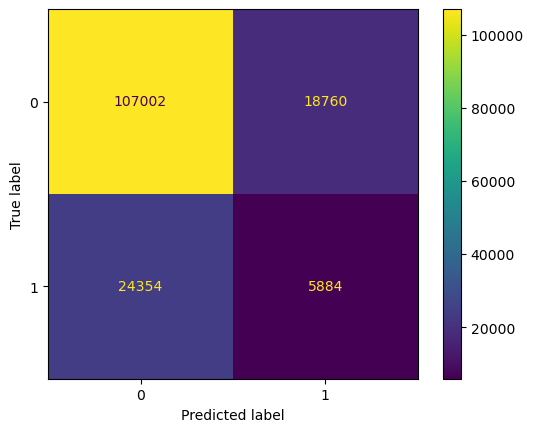

In [287]:
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
sklearn.metrics.confusion_matrix

In [288]:
correct_idxs = []
false_negative = []
false_positive = []

for i in range(pred_len):
    if all_preds[i] == 1 and test_labels[:pred_len][i] == 1:
        correct_idxs.append(i)
    if all_preds[i] == 1 and test_labels[:pred_len][i] == 0:
        false_positive.append(i)
    if all_preds[i] == 0 and test_labels[:pred_len][i] == 1:
        false_negative.append(i)

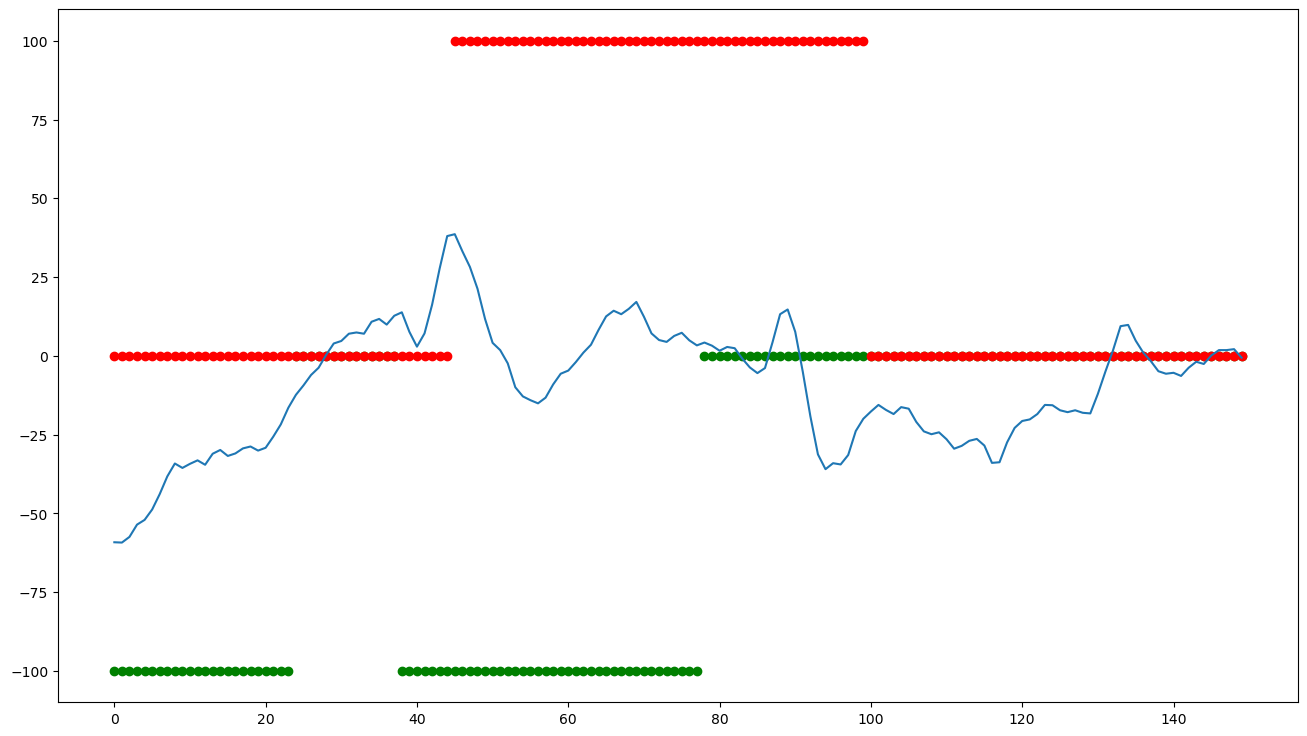

In [294]:
range_start = 2050
range_end = 2200

plt.figure(figsize=(16, 9))
plt.plot(test_x[2, :pred_len][range_start:range_end])
plt.scatter(x=list(range(range_end - range_start)), y=test_labels[:pred_len][range_start:range_end] * -100, color="green")
plt.scatter(x=list(range(range_end - range_start)), y=all_preds[range_start:range_end] * 100, color="red")